# Copyright
<PRE>
Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott 
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning 
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérjük az alábbi szerzőt értesíteni.

2017 (c) Szaszák György (szaszak kukac tmit pont bme pont hu)
</PRE>

A feladat, hogy 2 python alól is elérhető word2vec alkalmazással szóbeágyazásokat generáljunk, és ezeket összevessük, illetve fasttext-tel a karakter N-gram alapú "rásegítés" hatásait elemezzük.

In [3]:
# Angol wikipédia mentésen dolgozunk

import os.path

if not os.path.isfile('text8'):
    !wget -c http://mattmahoney.net/dc/text8.zip
    !unzip text8.zip

Archive:  text8.zip
  inflating: text8                   


In [13]:
import fasttext

# Fasttext felparaméterezése
lr = 0.05
dim = 100
ws = 5
epoch = 5
minCount = 5
neg = 5
loss = 'ns'
t = 1e-4

from gensim.models import Word2Vec
from gensim.models.word2vec import Text8Corpus

# gensim word2vec felparaméterezése (az összehasonlíthatósághoz ugyanúgy)
params = {
    'alpha': lr,
    'size': dim,
    'window': ws,
    'iter': epoch,
    'min_count': minCount,
    'sample': t,
    'sg': 1,
    'hs': 0,
    'negative': neg
}

In [7]:
# Tanítsunk be három modellt (hosszú, i7 4 magon kb 20 perc a 3 együtt)

# Fasttext skipgram model
skipgram_model = fasttext.skipgram('text8', 'fasttext_model', lr=lr, dim=dim, ws=ws, epoch=epoch, neg=neg, loss=loss, t=t)

# Fasttext skipgram model karakter N-gramok nélkül (default 3..6 lenne)
skipgram_nc_model = fasttext.skipgram('text8', 'fasttext_nochar_model', lr=lr, dim=dim, ws=ws, epoch=epoch, neg=neg, loss=loss, t=t, maxn=0)

# Gensim word2vec
gs_model = Word2Vec(Text8Corpus('text8'), **params)
gs_model.wv.save_word2vec_format('gensim_model')

DeprecationWarning: Deprecated. Use model.wv.save_word2vec_format instead.

## Embeddingek kiértékelése

Annál jobbnak tekintjük a beágyazást, minél inkább koherens, azaz az egyes leképezett szavak alaki (toldalékolás) és jelentésbeli konzekvens megfeleléseit jól tükrözi. Maga a nyelv sem konzekvens és koherens ebből a szempontból egyébként, ezért nem várhatunk komplett és minden relációt jól tükröző modellt, de ha ebbe az irányba haladunk, az már jó eredmény.

A kiértékelést két szempont szerint szokás végezni, az egyik alaki, a másik jelentés szerint működik. Az alapötlet mindkét esetben hasonló:

### Módhatározó képzése melléknévből:
diff_adverbial_reference = ( suddenly - sudden)

diff_adverbial_test = ( calmly - diff_adverbial_reference )

similarity (diff_adverbial_test, calmly) = ?

### Jelentésbeli hasonlóság konzekvens leképezése:
diff_pure_kingness = ( king - man )

sum_pure_kingness_and_woman = ( woman + diff_pure_kingness )

similarity (sum_pure_kingness_and_woman, queen) = ?


In [17]:
# szóbeágyazások összehasonlítására szolgáló mintafájl
!wget https://raw.githubusercontent.com/tmikolov/word2vec/master/questions-words.txt

--2017-11-22 21:03:55--  https://raw.githubusercontent.com/tmikolov/word2vec/master/questions-words.txt
raw.githubusercontent.com (raw.githubusercontent.com) feloldása… 151.101.12.133
Csatlakozás a következőhöz: raw.githubusercontent.com (raw.githubusercontent.com)[151.101.12.133]:443… kapcsolódva.
HTTP kérés elküldve, várakozás válaszra… 200 OK
Hossz: 603955 (590K) [text/plain]
Mentés ide: „questions-words.txt”

100%[======================================>] 603.955     1,80MB/s   idő 0,3s  

2017-11-22 21:03:56 (1,80 MB/s) -- „questions-words.txt” mentve [603955/603955]



In [2]:
# Összehasonlításhoz a logolást bőbeszédűbbre állítjuk
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Segédfüggvény alapos teszteléshez (https://github.com/jayantj/gensim/blob/9f3e275ddad22afd54b7986654f3033f9baf8983/docs/notebooks/Word2Vec_FastText_Comparison)

def print_accuracy(model, questions_file):
    print('Evaluating...\n')
    acc = model.accuracy(questions_file)

    # Jelentésreprezentációbeli illeszkedés (szemantikai hasonlóság, azaz közel eső jelentés)
    sem_correct = sum((len(acc[i]['correct']) for i in range(5)))
    sem_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5))
    sem_acc = 100*float(sem_correct)/sem_total
    print('\nSemantic: {:d}/{:d}, Accuracy: {:.2f}%'.format(sem_correct, sem_total, sem_acc))
    
    # Hasonló íráskép alapú illeszkedés (szintaktikai hasonlóság, azaz közel eső szóalak)
    syn_correct = sum((len(acc[i]['correct']) for i in range(5, len(acc)-1)))
    syn_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5,len(acc)-1))
    syn_acc = 100*float(syn_correct)/syn_total
    print('Syntactic: {:d}/{:d}, Accuracy: {:.2f}%\n'.format(syn_correct, syn_total, syn_acc))
    return (sem_acc, syn_acc)


In [3]:
from gensim.models.keyedvectors import KeyedVectors

word_analogies_file = 'questions-words.txt'
accuracies = []

print('\nLoading Gensim embeddings') # betöltjük, mert a tanítást nem várjuk végig, korábban lefuttattuk
model_gensim = KeyedVectors.load_word2vec_format('gensim_model.vec')
print('Accuracy for Word2Vec:')
accuracies.append(print_accuracy(model_gensim, word_analogies_file))

print('\nLoading FastText embeddings')
fasttext_model = KeyedVectors.load_word2vec_format('fasttext_model.vec')
print('Accuracy for FastText (with n-grams):')
accuracies.append(print_accuracy(fasttext_model, word_analogies_file))

print('\nLoading FastText embeddings without char N-gram')
fasttext_nc_model = KeyedVectors.load_word2vec_format('fasttext_nochar_model.vec')
print('Accuracy for FastText (without n-grams):')
accuracies.append(print_accuracy(fasttext_nc_model, word_analogies_file))



2017-11-23 09:43:48,864 : INFO : 'pattern' package not found; tag filters are not available for English
2017-11-23 09:43:48,869 : INFO : loading projection weights from gensim_model.vec



Loading Gensim embeddings


2017-11-23 09:43:55,019 : INFO : loaded (71290, 100) matrix from gensim_model.vec
2017-11-23 09:43:55,055 : INFO : precomputing L2-norms of word weight vectors


Accuracy for Word2Vec:
Evaluating...



2017-11-23 09:43:57,782 : INFO : capital-common-countries: 70.0% (354/506)
2017-11-23 09:44:05,786 : INFO : capital-world: 47.5% (689/1452)
2017-11-23 09:44:07,495 : INFO : currency: 20.1% (54/268)
2017-11-23 09:44:16,402 : INFO : city-in-state: 23.2% (365/1571)
2017-11-23 09:44:18,312 : INFO : family: 62.1% (190/306)
2017-11-23 09:44:22,670 : INFO : gram1-adjective-to-adverb: 15.7% (119/756)
2017-11-23 09:44:24,450 : INFO : gram2-opposite: 15.4% (47/306)
2017-11-23 09:44:31,676 : INFO : gram3-comparative: 49.0% (618/1260)
2017-11-23 09:44:35,902 : INFO : gram4-superlative: 29.2% (148/506)
2017-11-23 09:44:43,571 : INFO : gram5-present-participle: 26.4% (262/992)
2017-11-23 09:44:55,226 : INFO : gram6-nationality-adjective: 75.6% (1037/1371)
2017-11-23 09:45:06,074 : INFO : gram7-past-tense: 32.9% (438/1332)
2017-11-23 09:45:12,971 : INFO : gram8-plural: 44.4% (440/992)
2017-11-23 09:45:16,984 : INFO : gram9-plural-verbs: 25.2% (164/650)
2017-11-23 09:45:16,986 : INFO : total: 40.1% (4


Semantic: 1652/4103, Accuracy: 40.26%
Syntactic: 3273/8165, Accuracy: 40.09%


Loading FastText embeddings


2017-11-23 09:45:23,479 : INFO : loaded (71290, 100) matrix from fasttext_model.vec
2017-11-23 09:45:23,506 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText (with n-grams):
Evaluating...



2017-11-23 09:45:26,416 : INFO : capital-common-countries: 62.6% (317/506)
2017-11-23 09:45:36,919 : INFO : capital-world: 42.8% (622/1452)
2017-11-23 09:45:38,772 : INFO : currency: 15.3% (41/268)
2017-11-23 09:45:47,095 : INFO : city-in-state: 20.3% (306/1511)
2017-11-23 09:45:48,823 : INFO : family: 49.0% (150/306)
2017-11-23 09:45:52,614 : INFO : gram1-adjective-to-adverb: 71.6% (541/756)
2017-11-23 09:45:54,194 : INFO : gram2-opposite: 55.6% (170/306)
2017-11-23 09:46:00,812 : INFO : gram3-comparative: 71.0% (894/1260)
2017-11-23 09:46:03,452 : INFO : gram4-superlative: 53.8% (272/506)
2017-11-23 09:46:08,583 : INFO : gram5-present-participle: 57.2% (567/992)
2017-11-23 09:46:15,638 : INFO : gram6-nationality-adjective: 94.1% (1290/1371)
2017-11-23 09:46:22,510 : INFO : gram7-past-tense: 35.9% (478/1332)
2017-11-23 09:46:27,649 : INFO : gram8-plural: 87.1% (864/992)
2017-11-23 09:46:31,019 : INFO : gram9-plural-verbs: 56.3% (366/650)
2017-11-23 09:46:31,022 : INFO : total: 56.3% (


Semantic: 1436/4043, Accuracy: 35.52%
Syntactic: 5442/8165, Accuracy: 66.65%


Loading FastText embeddings without char N-gram


2017-11-23 09:46:36,830 : INFO : loaded (71290, 100) matrix from fasttext_nochar_model.vec
2017-11-23 09:46:36,929 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText (without n-grams):
Evaluating...



2017-11-23 09:46:39,614 : INFO : capital-common-countries: 73.7% (373/506)
2017-11-23 09:46:47,149 : INFO : capital-world: 47.5% (690/1452)
2017-11-23 09:46:48,560 : INFO : currency: 19.4% (52/268)
2017-11-23 09:46:57,920 : INFO : city-in-state: 25.7% (388/1511)
2017-11-23 09:46:59,919 : INFO : family: 52.9% (162/306)
2017-11-23 09:47:04,573 : INFO : gram1-adjective-to-adverb: 13.8% (104/756)
2017-11-23 09:47:06,562 : INFO : gram2-opposite: 14.1% (43/306)
2017-11-23 09:47:14,413 : INFO : gram3-comparative: 52.2% (658/1260)
2017-11-23 09:47:17,680 : INFO : gram4-superlative: 27.7% (140/506)
2017-11-23 09:47:24,310 : INFO : gram5-present-participle: 21.9% (217/992)
2017-11-23 09:47:31,626 : INFO : gram6-nationality-adjective: 79.5% (1090/1371)
2017-11-23 09:47:38,752 : INFO : gram7-past-tense: 30.0% (399/1332)
2017-11-23 09:47:44,138 : INFO : gram8-plural: 53.7% (533/992)
2017-11-23 09:47:48,241 : INFO : gram9-plural-verbs: 26.8% (174/650)
2017-11-23 09:47:48,251 : INFO : total: 41.1% (5


Semantic: 1665/4043, Accuracy: 41.18%
Syntactic: 3358/8165, Accuracy: 41.13%



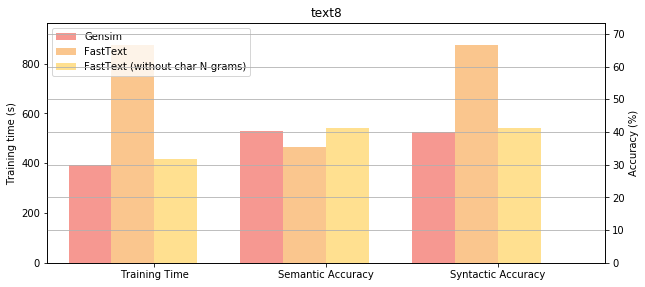

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(ax, data, corpus_name='text8'):
    width = 0.25
    pos = [(i, i + width, i + 2*width) for i in range(len(data))]
    colors = ['#EE3224', '#F78F1E', '#FFC222']
    acc_ax = ax.twinx()
    # tanítási idő (most nem játszik)
    ax.bar(pos[0],
            data[0],
            width,
            alpha=0.5,
            color=colors
            )
    # Szemantikus pontosság (acc)
    acc_ax.bar(pos[1],
            data[1],
            width,
            alpha=0.5,
            color=colors
            )

    # Szintaktikai pontosság (acc)
    acc_ax.bar(pos[2],
            data[2],
            width,
            alpha=0.5,
            color=colors
            )

    ax.set_ylabel('Training time (s)')
    acc_ax.set_ylabel('Accuracy (%)')
    ax.set_title(corpus_name)

    acc_ax.set_xticks([p[0] + 1.5 * width for p in pos])
    acc_ax.set_xticklabels(['Training Time', 'Semantic Accuracy', 'Syntactic Accuracy'])

    # Tengelyfeliratokhoz trükközés
    proxies = [ax.bar([0], [0], width=0, color=c, alpha=0.5)[0] for c in colors]
    models = ('Gensim', 'FastText', 'FastText (without char N-grams)')
    ax.legend((proxies), models, loc='upper left')
    
    ax.set_xlim(pos[0][0]-width, pos[-1][0]+width*4)
    ax.set_ylim([0, max(data[0])*1.1] )
    acc_ax.set_ylim([0, max(data[1] + data[2])*1.1] )

    plt.grid()

# Megjelenítés ábrán
fig = plt.figure(figsize=(10,15))
evaluation_data = {}
evaluation_data['text8'] = [(392, 876, 416)] # A tanítási időket most átemeltük korábbról fixen, mert nincs idő futtatni az órán
evaluation_data['text8'] += [[acc[0] for acc in accuracies], [acc[1] for acc in accuracies]]

for corpus, subplot in zip(sorted(evaluation_data.keys()), [311, 312, 313]):
    ax = fig.add_subplot(subplot)
    plot(ax, evaluation_data[corpus], corpus)

plt.show()